In [1]:
from __future__ import division
from pyomo.environ import *
from pyomo.opt import SolverStatus, TerminationCondition
import pandas as pd
import time
#import pyutilib.services
#import pickle
import random
import sqlite3
import itertools
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import numpy as np
#from samternary.ternary import Ternary
import multiprocessing as mp
#import pathos as pmp
#import dill
#from pathos.multiprocessing import ProcessingPool as Pool
import geopandas as gpd
import networkx as nx
import random
from shapely.geometry import Polygon



path = "S:/Users/onahorna/spatial_paper/Data/2025-03-10_full_data"

In [2]:
#code with iteration for creating clusters and validation that young cells are only grouped with each other
#note: in this code, the term "cluster" was used for both segments and clusters
#names "stand" and "cell" are sometimes used interchangably, but also mean the same in the context of this code, refering to the basic unit that is to be grouped into segments/clusters


path = #define path to the input folder

countries_gdf = gpd.read_file(path + "/Full_dataset_cells.shp")  #shapefile with cells
map1 = countries_gdf


#some data cleaning - optional
map1["D_new"] = map1["D"]
map1["H_new"] = map1["H"]
map1["Ho_new"] = map1["Ho"]

#some data cleaning - optional
map1.loc[(map1["VOLUMPROS_"] == 0) & (map1["VOLUMPRO_1"] == 0) & (map1["VOLUMPRO_2"] == 0), "D_new"] = 0
map1.loc[(map1["VOLUMPROS_"] == 0) & (map1["VOLUMPRO_1"] == 0) & (map1["VOLUMPRO_2"] == 0), "H_new"] = 0
map1.loc[(map1["VOLUMPROS_"] == 0) & (map1["VOLUMPRO_1"] == 0) & (map1["VOLUMPRO_2"] == 0), "Ho_new"] = 0


#Optional in case of presence of young recently clearcut areas 
#Validation part to ensure that within a cluster all young cells could only be joined into segments with each other 

allowed_cells_df = pd.read_csv(path + "/cells_young.csv")  #load csv file that includes list of all young cells
allowed_stand_ids = set(allowed_cells_df['standID'])

#young cells validation function: for every cluster that contains one of the allowed cells, check that every cell in that cluster has a standID in the allowed cells list
def validate_clusters(gdf, allowed_ids):
    #identify clusters that contain at least one allowed cell 
    clusters_to_check = gdf[gdf['OBJECTID'].isin(allowed_ids)]['cluster'].unique()
    
    for cluster in clusters_to_check:
        #get all OBJECTIDs in this cluster
        cluster_ids = set(gdf[gdf['cluster'] == cluster]['OBJECTID'])
        #check if the entire cluster is a subset of allowed_ids
        if not cluster_ids.issubset(allowed_ids):
            return False  
    
    return True  #if all clusters are valid

#clustering functions 

#for defining neighbors
def compute_neighbors(gdf):
    if gdf.crs.to_epsg() != 25832:
        raise ValueError("GeoDataFrame must be in ETRS 1989 UTM Zone 32N (EPSG:25832) projection.")
    neighbors = []
    spatial_index = gdf.sindex
    for idx, cell in gdf.iterrows():
        possible_matches_index = list(spatial_index.intersection(cell.geometry.bounds))
        possible_matches = gdf.iloc[possible_matches_index]
        cell_neighbors = []
        #assigning different weights for orthogonal and diagonal neighbors
        for neighbor_idx, neighbor in possible_matches.iterrows():
            if neighbor_idx != idx and cell.geometry.touches(neighbor.geometry):
                weight = 1 if cell.geometry.intersection(neighbor.geometry).length > 0 else 0
                cell_neighbors.append({'cell_index': neighbor_idx, 'cluster': neighbor['cluster'], 'weight': weight})
        neighbors.append(cell_neighbors)
    gdf['neighbors'] = neighbors
    return gdf


#function for computing cluster charactestics - mean of all cells within a given cluster
def calculate_cluster_characteristics(map1, cluster_cells):
    cluster_data = map1.loc[list(cluster_cells), ['Ho_new', 'D_new']]
    return {
        'height_mean': cluster_data['Ho_new'].mean(),
        'diameter_mean': cluster_data['D_new'].mean()
    }


#function that checks if a neighbor considered for adding to the cluster is within an allowable threshold
def is_within_threshold(cell, cluster, thresholds):
    def within_relative_threshold(value, mean, threshold):
        if mean == 0:
            return abs(value - mean) <= threshold  
        return abs(value - mean) / mean <= threshold
    return (
        within_relative_threshold(cell['Ho_new'], cluster['height_mean'], thresholds['height']) and
        within_relative_threshold(cell['D_new'], cluster['diameter_mean'], thresholds['diameter']) 
    )


#function that grows the clusters - Step 1
def grow_cluster(map1, initial_cell_idx, max_size, thresholds):
    cluster_cells = {initial_cell_idx}
    map1.at[initial_cell_idx, 'cluster'] = map1.at[initial_cell_idx, 'cluster']
    while len(cluster_cells) < max_size:
        new_cells = set()
        cluster_characteristics = calculate_cluster_characteristics(map1, cluster_cells)
        for cell_idx in list(cluster_cells):
            neighbors = map1.at[cell_idx, 'neighbors']
            random.shuffle(neighbors)
            for neighbor in neighbors:
                neighbor_idx = neighbor['cell_index']
                if (neighbor_idx not in cluster_cells and 
                    map1.at[neighbor_idx, 'cluster'] == -1 and 
                    neighbor['weight'] > 0):
                    if is_within_threshold(map1.loc[neighbor_idx], cluster_characteristics, thresholds):
                        new_cells.add(neighbor_idx)
        if not new_cells:
            break
        selected_new_cells = random.sample(list(new_cells), min(len(new_cells), random.randint(1, len(new_cells))))
        for new_cell in selected_new_cells:
            map1.at[new_cell, 'cluster'] = map1.at[initial_cell_idx, 'cluster']
            cluster_cells.add(new_cell)
    return cluster_cells


#function to start new cluster from a random unclustered cell
def random_growth_clusteration(map1, max_size, thresholds):
    cluster_id = 0
    unclustered_cells = map1[map1['cluster'] == -1].index.tolist()
    while unclustered_cells:
        initial_cell_idx = random.choice(unclustered_cells)
        map1.at[initial_cell_idx, 'cluster'] = cluster_id
        grow_cluster(map1, initial_cell_idx, max_size, thresholds)
        unclustered_cells = map1[map1['cluster'] == -1].index.tolist()
        cluster_id += 1
    return map1


#Step 2 - cleaning one - define all small clusters and merge with neighbor if feasible
def merge_small_clusters(map1, thresholds):
    small_clusters = map1.groupby('cluster').size()
    small_clusters = small_clusters[small_clusters <= 4].index.tolist()
    for cluster_id in small_clusters:
        small_cluster_cells = map1[map1['cluster'] == cluster_id].index.tolist()
        neighbor_clusters = set()
        for cell_idx in small_cluster_cells:
            neighbors = map1.at[cell_idx, 'neighbors']
            for neighbor in neighbors:
                neighbor_idx = neighbor['cell_index']
                neighbor_cluster = map1.at[neighbor_idx, 'cluster']
                if neighbor_cluster != cluster_id and neighbor_cluster != -1:
                    cell_geometry = map1.at[cell_idx, 'geometry']
                    neighbor_geometry = map1.at[neighbor_idx, 'geometry']
                    if not cell_geometry.intersection(neighbor_geometry).is_empty:
                        neighbor_clusters.add(neighbor_cluster)
        if not neighbor_clusters:
            continue
        small_cluster_data = map1.loc[small_cluster_cells, ['Ho_new', 'D_new']]
        small_cluster_means = {
            'height_mean': small_cluster_data['Ho_new'].mean(),
            'diameter_mean': small_cluster_data['D_new'].mean()
        }
        best_neighbor = None
        smallest_diff = float('inf')
        for neighbor_cluster in neighbor_clusters:
            neighbor_cells = map1[map1['cluster'] == neighbor_cluster].index.tolist()
            neighbor_data = map1.loc[neighbor_cells, ['Ho_new', 'D_new']]
            neighbor_means = {
                'height_mean': neighbor_data['Ho_new'].mean(),
                'diameter_mean': neighbor_data['D_new'].mean()
            }
            height_rel_diff = abs(small_cluster_means['height_mean'] - neighbor_means['height_mean']) / max(small_cluster_means['height_mean'], neighbor_means['height_mean'], 1e-6)
            diameter_rel_diff = abs(small_cluster_means['diameter_mean'] - neighbor_means['diameter_mean']) / max(small_cluster_means['diameter_mean'], neighbor_means['diameter_mean'], 1e-6)
            
            total_diff = height_rel_diff + diameter_rel_diff 
            if (total_diff < smallest_diff and
                height_rel_diff <= thresholds['height_rel'] and
                diameter_rel_diff <= thresholds['diameter_rel']):
                smallest_diff = total_diff
                best_neighbor = neighbor_cluster
        if best_neighbor is not None:
            for cell_idx in small_cluster_cells:
                map1.at[cell_idx, 'cluster'] = best_neighbor
    return map1

#save the cluster information to the dictionary
def save_clustering_to_dict(map1, grouping_options, run_id):
    grouping_options[run_id] = {}
    for cluster_id in sorted(map1['cluster'].unique()):
        object_ids = sorted(map1[map1['cluster'] == cluster_id]['OBJECTID'].tolist())
        grouping_options[run_id][cluster_id] = object_ids
    return grouping_options

#Block for iterative clustering
grouping_options = {}
num_runs_per_batch = 22 #define how many clusters will be created in each batch
possible_thresholds = [0.2, 0.25, 0.3, 0.35, 0.4]  #allowed threshold values (percentage difference)


#Code to run the separate batches  

#One iteration creates one cluster 

#Batch 1 and 2 were test runs - thus commented out here

# #Batch 1
# for run_id in range(0,num_runs_per_batch):
#     valid = False
#     while not valid:
#         #randomly select thresholds for this run from the possible thresholds
#         selected_height_threshold = random.choice(possible_thresholds)
#         selected_diameter_threshold = random.choice(possible_thresholds)
#         print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        
#         #reset clusters and define neighbors
#         map1['cluster'] = -1
#         map1 = compute_neighbors(map1)
        
#         #run clustering with the randomly selected thresholds and chosen max_size 
#         clustered_map = random_growth_clusteration(map1, max_size=10,
#                                                     thresholds={'height': selected_height_threshold,
#                                                                 'diameter': selected_diameter_threshold})
#         #Step 2 - post-cleaning merge with fixed thresholds (adjust as needed directly here)
#         map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        
#         #Check that clusters containing young cells are only grouped with other young cells
#         if validate_clusters(map1, allowed_stand_ids):
#             valid = True
#         else:
#             print(f"Validation failed in Batch 1, run {run_id}. Restarting iteration...")
    
#     grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
# print("Batch 1 completed.")


# #Batch 2
# for run_id in range(num_runs_per_batch, 2 * num_runs_per_batch):
#     valid = False
#     while not valid:
#         selected_height_threshold = random.choice(possible_thresholds)
#         selected_diameter_threshold = random.choice(possible_thresholds)
#         print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
#         map1['cluster'] = -1
#         map1 = compute_neighbors(map1)
#         clustered_map = random_growth_clusteration(map1, max_size=15,
#                                                     thresholds={'height': selected_height_threshold,
#                                                                 'diameter': selected_diameter_threshold})
#         map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
#         if validate_clusters(map1, allowed_stand_ids):
#             valid = True
#         else:
#             print(f"Validation failed in Batch 2, run {run_id}. Restarting iteration...")
    
#     grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
# print("Batch 2 completed.")

# Batch 3
for run_id in range(2 * num_runs_per_batch, 3 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=20,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 3, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 3 completed.")

# Batch 4
for run_id in range(3 * num_runs_per_batch, 4 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=25,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 4, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 4 completed.")

# Batch 5
for run_id in range(4 * num_runs_per_batch, 5 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=30,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 5, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 5 completed.")

# Batch 6
for run_id in range(5 * num_runs_per_batch, 6 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=35,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 6, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 6 completed.")

# Batch 7
for run_id in range(6 * num_runs_per_batch, 7 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=40,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 7, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 7 completed.")

# Batch 8
for run_id in range(7 * num_runs_per_batch, 8 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=45,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 8, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 8 completed.")

# Batch 9
for run_id in range(8 * num_runs_per_batch, 9 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=50,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 9, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 9 completed.")

# Batch 10
for run_id in range(9 * num_runs_per_batch, 10 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=55,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 10, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 10 completed.")

# Batch 11
for run_id in range(10 * num_runs_per_batch, 11 * num_runs_per_batch):
    valid = False
    while not valid:
        selected_height_threshold = random.choice(possible_thresholds)
        selected_diameter_threshold = random.choice(possible_thresholds)
        print(f"Run {run_id}: Selected thresholds for clustering: height = {selected_height_threshold}, diameter = {selected_diameter_threshold}")
        map1['cluster'] = -1
        map1 = compute_neighbors(map1)
        clustered_map = random_growth_clusteration(map1, max_size=60,
                                                    thresholds={'height': selected_height_threshold,
                                                                'diameter': selected_diameter_threshold})
        map1 = merge_small_clusters(clustered_map, thresholds={'height_rel': 0.6, 'diameter_rel': 0.6})
        if validate_clusters(map1, allowed_stand_ids):
            valid = True
        else:
            print(f"Validation failed in Batch 11, run {run_id}. Restarting iteration...")
    
    grouping_options = save_clustering_to_dict(map1, grouping_options, run_id)
    
print("Batch 11 completed.")


print(grouping_options)


Run 44: Selected thresholds for clustering: height = 0.2, diameter = 0.2
Run 45: Selected thresholds for clustering: height = 0.4, diameter = 0.3
Run 46: Selected thresholds for clustering: height = 0.4, diameter = 0.3
Run 47: Selected thresholds for clustering: height = 0.3, diameter = 0.25
Run 48: Selected thresholds for clustering: height = 0.35, diameter = 0.3
Run 49: Selected thresholds for clustering: height = 0.3, diameter = 0.3
Run 50: Selected thresholds for clustering: height = 0.2, diameter = 0.2
Run 51: Selected thresholds for clustering: height = 0.2, diameter = 0.25
Run 52: Selected thresholds for clustering: height = 0.3, diameter = 0.3
Run 53: Selected thresholds for clustering: height = 0.25, diameter = 0.2
Run 54: Selected thresholds for clustering: height = 0.2, diameter = 0.35
Run 55: Selected thresholds for clustering: height = 0.25, diameter = 0.4
Run 56: Selected thresholds for clustering: height = 0.35, diameter = 0.25
Run 57: Selected thresholds for clustering:

In [3]:
#Saving the dictionary with clustering information

import pickle

file_path = r"S:\Data\grouping_test.pkl"  

with open(file_path, "wb") as f:
    pickle.dump(grouping_options, f)


In [8]:
#pretty pring the dictiomary with clusters
for cluster, segments in grouping_options.items():
    print(f"Cluster {cluster}:")
    for segment, stands in segments.items():
        print(f"  Segment {segment}: {stands}")
    print()  

Cluster 44:
  Segment 0: [308988, 309041, 309044, 309046, 309048, 309050, 309051, 309098, 309099, 309100, 309101, 309102, 309103, 309104, 309143, 309144, 309145, 309191, 309192, 309193, 309242, 309243, 309244, 309245, 309246, 309292, 309293, 309296, 309297]
  Segment 1: [345274, 345332, 345333, 345374, 345375, 345377, 345380, 345381, 345419, 345423, 345425, 345465, 346867, 346905, 346909, 346949, 346950, 346951, 346952, 346953, 346993, 346994, 346995, 346996, 347036, 347037, 347038, 347039, 347073]
  Segment 2: [309848, 346197, 346198, 346247, 346248, 346294, 346296, 346297, 346347, 346349, 346350, 346398, 346400, 346401, 346451, 346452, 346453, 346454, 346500, 346501, 346502, 346503, 346539, 346541, 346542, 346543, 346544, 346578, 346580]
  Segment 3: [344878, 346555, 346556, 346590, 346591, 346592, 346593, 346594, 346595, 346628, 346629, 346630, 346631, 346632, 346633, 346634, 346665, 346666, 346667, 346668, 346669, 346670, 346703, 346707, 346741]
  Segment 4: [307915, 307916, 307917

In [5]:
#this code is for analysing one cluster at a time if needed

file_path = r"S:\Data\grouping_test.pkl"  

#load the dictionary from the pickle file
with open(file_path, 'rb') as f:
    grouping_options = pickle.load(f)

#cluster ID to analyze
cluster_id = 90

#checking if cluster exists in the data
if cluster_id in grouping_options:
    segments = grouping_options[cluster_id]

    #total number of segments
    num_segments = len(segments)

    #count stands (cells) per segment
    stand_counts = [len(stands) for stands in segments.values()]

    #total number of stands (cells)
    total_stands = sum(stand_counts)

    #min, max, and average number of stands (cells) per segment
    min_stands = min(stand_counts) if stand_counts else 0
    max_stands = max(stand_counts) if stand_counts else 0
    avg_stands = total_stands / num_segments if num_segments > 0 else 0

   
    print(f"Analysis for Cluster {cluster_id}:")
    print(f"  Total segments: {num_segments}")
    print(f"  Total stands: {total_stands}")
    print(f"  Min stands in a segment: {min_stands}")
    print(f"  Max stands in a segment: {max_stands}")
    print(f"  Average stands per segment: {avg_stands:.2f}")
else:
    print(f"Cluster {cluster_id} not found in grouping_options")


Analysis for Cluster 90:
  Total segments: 62
  Total stands: 1719
  Min stands in a segment: 6
  Max stands in a segment: 46
  Average stands per segment: 27.73


In [6]:
#This code for saving clustering information to the simulation output file
#This code simply adds a new column for each cluster, where it identifies with number what segment ID that cell belongs within that cluster
#Generates the file that will be further used for optimizatio

print("Loading input file...")
df = pd.read_parquet(path + "/Optimization_input/2025-03-18_cells_30_complete_hsi.parquet") 
print(f"Input DataFrame loaded with {len(df)} rows and {len(df.columns)} columns.")

#load the grouping_options file (distionary with clustering information)
print("Loading grouping_options dictionary from pickle...") 
group_path = r"S:\Data\grouping_test.pkl"  
with open(group_path, "rb") as f:
    grouping_options = pickle.load(f)
print(f"Grouping options loaded with {len(grouping_options)} clusters.")

print("Creating new DataFrame for new columns (pre-filled with None)...")
new_cols = {f'cluster_{cluster}': [None] * len(df) for cluster in grouping_options.keys()}
new_cols_df = pd.DataFrame(new_cols, index=df.index)
print(f"New columns DataFrame created with {new_cols_df.shape[1]} columns.")

print("Assigning segment numbers based on the 'stand' field and grouping_options...")
for cluster, segments in grouping_options.items():
    print(f"  Processing cluster: {cluster} with {len(segments)} segments.")
    for segment, ids in segments.items():
        print(f"    Assigning segment {segment} for {len(ids)} IDs.")
        new_cols_df.loc[df['stand'].isin(ids), f'cluster_{cluster}'] = segment

print("Concatenating new columns with the original DataFrame...")
df_updated = pd.concat([df, new_cols_df], axis=1)
print(f"Updated DataFrame has {df_updated.shape[1]} columns.")


print("Saving the updated DataFrame to file...")
df_updated.to_parquet(path + "/Optimization_input/test_08.parquet", index=False)
print("File saved.")

print("Displaying first few rows of the updated DataFrame:")
print(df_updated.head())


Loading input file...
Input DataFrame loaded with 1671744 rows and 48 columns.
Loading grouping_options dictionary from pickle...
Grouping options loaded with 198 clusters.
Creating new DataFrame for new columns (pre-filled with None)...
New columns DataFrame created with 198 columns.
Assigning segment numbers based on the 'stand' field and grouping_options...
  Processing cluster: 44 with 82 segments.
    Assigning segment 0 for 29 IDs.
    Assigning segment 1 for 29 IDs.
    Assigning segment 2 for 29 IDs.
    Assigning segment 3 for 25 IDs.
    Assigning segment 4 for 25 IDs.
    Assigning segment 5 for 29 IDs.
    Assigning segment 6 for 36 IDs.
    Assigning segment 7 for 24 IDs.
    Assigning segment 8 for 27 IDs.
    Assigning segment 9 for 24 IDs.
    Assigning segment 10 for 22 IDs.
    Assigning segment 11 for 25 IDs.
    Assigning segment 12 for 7 IDs.
    Assigning segment 13 for 26 IDs.
    Assigning segment 14 for 30 IDs.
    Assigning segment 15 for 29 IDs.
    Assigning

In [2]:
#Optional: used for further visualization
#Code to add information on selected clusters back to the shapefile

print("Loading shapefile...")
gdf = gpd.read_file(path + "/Shapefile/2025-03-12_Full_dataset_cells.shp")
print(f"Shapefile loaded with {len(gdf)} rows and {len(gdf.columns)} columns.")

#load the grouping_options file (distionary with clustering information)
group_path = r"S:\Data\grouping_test.pkl"  
print("Loading grouping_options dictionary from pickle...")
with open(group_path, "rb") as f:
    grouping_options = pickle.load(f)
print(f"Grouping options loaded with {len(grouping_options)} clusters.")

#only process selected clusters
selected_clusters = (56, 57, 59, 60, 81, 90)
grouping_options = {k: v for k, v in grouping_options.items() if k in selected_clusters}

#prepare new columns filled with None
print("Creating new columns for selected clusters...")
new_cols = {f'cluster_{cluster}': [None] * len(gdf) for cluster in grouping_options}
new_cols_df = pd.DataFrame(new_cols, index=gdf.index)

#assign values to new cluster columns based on OBJECTID matching
print("Assigning segment numbers based on OBJECTID...")
for cluster, segments in grouping_options.items():
    print(f"  Processing cluster {cluster} with {len(segments)} segments.")
    for segment, ids in segments.items():
        print(f"    Assigning segment {segment} to {len(ids)} OBJECTIDs.")
        new_cols_df.loc[gdf['OBJECTID'].isin(ids), f'cluster_{cluster}'] = segment

#concatenate the new columns to the GeoDataFrame
print("Merging new cluster columns with original GeoDataFrame...")
gdf_updated = pd.concat([gdf, new_cols_df], axis=1)

#save updated shapefile
print("Saving updated shapefile...")
gdf_updated.to_file(path + "/Shapefile/2025-04-29_Full_optimal_segments.shp")
print(f"Shapefile saved to {path + "/Shapefile/2025-04-29_Full_optimal_segments.shp"}.")

print("Displaying first few rows of the updated GeoDataFrame:")
print(gdf_updated.head())


Loading shapefile...
Shapefile loaded with 1719 rows and 47 columns.
Loading grouping_options dictionary from pickle...
Grouping options loaded with 198 clusters.
Creating new columns for selected clusters...
Assigning segment numbers based on OBJECTID...
  Processing cluster 56 with 86 segments.
    Assigning segment 0 to 20 OBJECTIDs.
    Assigning segment 2 to 31 OBJECTIDs.
    Assigning segment 3 to 23 OBJECTIDs.
    Assigning segment 4 to 22 OBJECTIDs.
    Assigning segment 5 to 32 OBJECTIDs.
    Assigning segment 6 to 17 OBJECTIDs.
    Assigning segment 7 to 26 OBJECTIDs.
    Assigning segment 8 to 25 OBJECTIDs.
    Assigning segment 9 to 37 OBJECTIDs.
    Assigning segment 10 to 34 OBJECTIDs.
    Assigning segment 11 to 21 OBJECTIDs.
    Assigning segment 12 to 29 OBJECTIDs.
    Assigning segment 13 to 22 OBJECTIDs.
    Assigning segment 14 to 28 OBJECTIDs.
    Assigning segment 15 to 22 OBJECTIDs.
    Assigning segment 16 to 34 OBJECTIDs.
    Assigning segment 17 to 24 OBJECTID

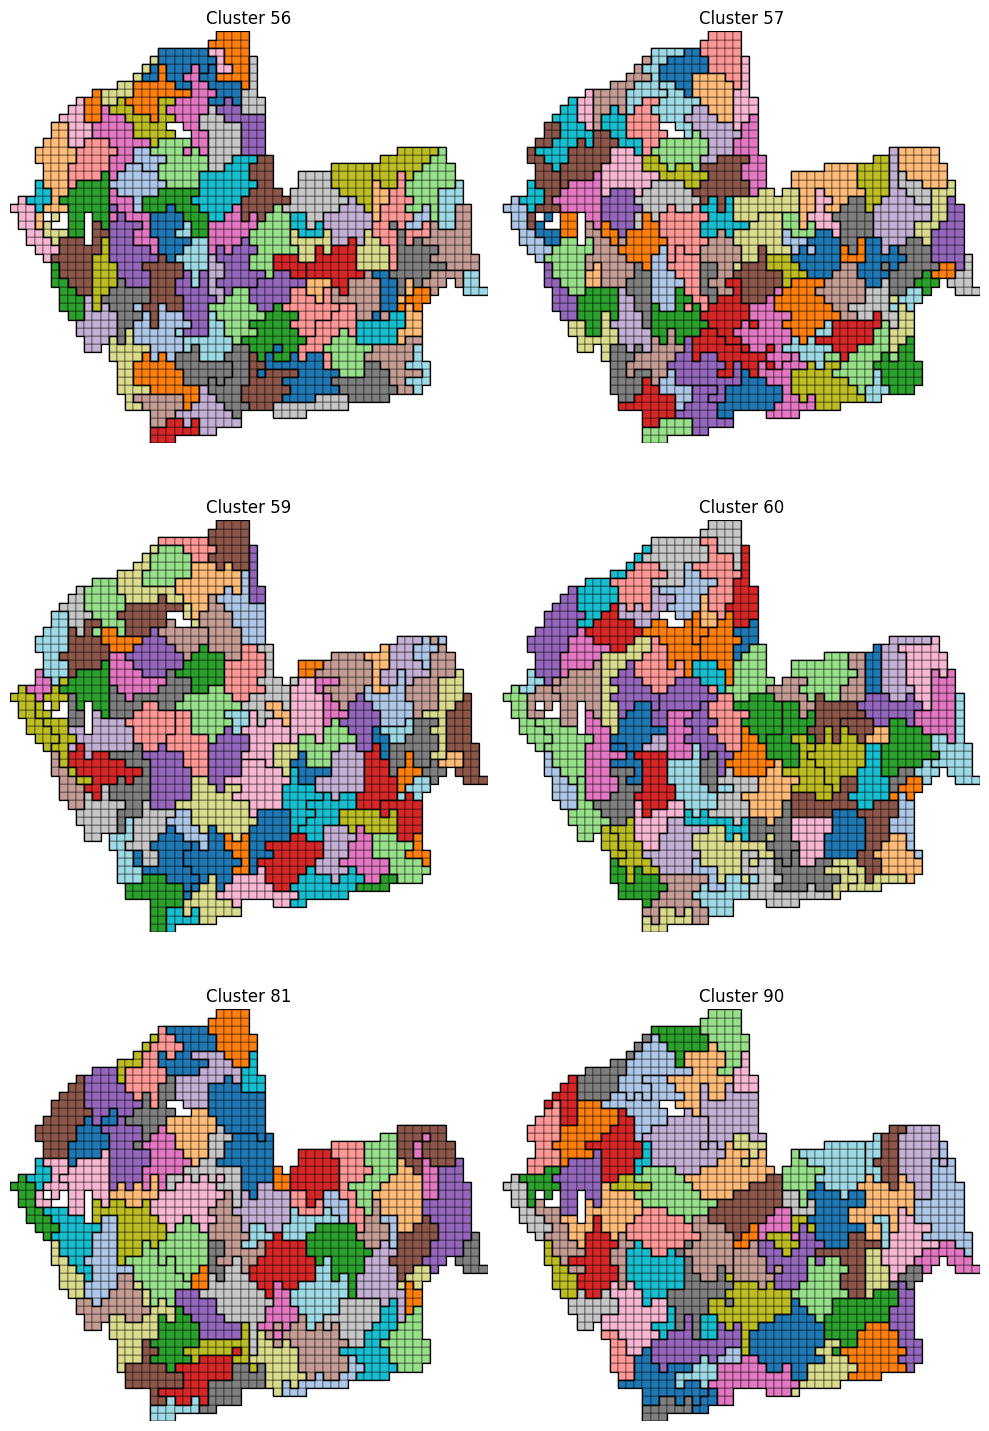

In [18]:
#visualization of selected clusters

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import pandas as pd
import numpy as np


shapefile_path = path + "/Shapefile/2025-04-29_Full_optimal_segments.shp"
gdf = gpd.read_file(shapefile_path)

#target clusters and corresponding columns
clusters = [56, 57, 59, 60, 81, 90]
cluster_columns = [f"cluster_{c}" for c in clusters]

n_segments_total = max(gdf[col].nunique() for col in cluster_columns)
cmap = plt.get_cmap('tab20', n_segments_total)

#create subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = axes.flatten()

#global map bounds
xlim = gdf.total_bounds[[0, 2]]
ylim = gdf.total_bounds[[1, 3]]

for idx, col in enumerate(cluster_columns):
    ax = axes[idx]
    title = f"Cluster {clusters[idx]}"
    gdf.plot(column=col, ax=ax, cmap=cmap, linewidth=0.3, edgecolor='black')

    #add dissolved boundaries
    dissolved = gdf.dissolve(by=col)
    dissolved.boundary.plot(ax=ax, linewidth=0.9, edgecolor='black')

    ax.set_title(title, fontsize=12)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.axis("off")


plt.tight_layout()
#plt.savefig(path + "/Figures/cluster_maps_grid.png", dpi=500)
plt.show()


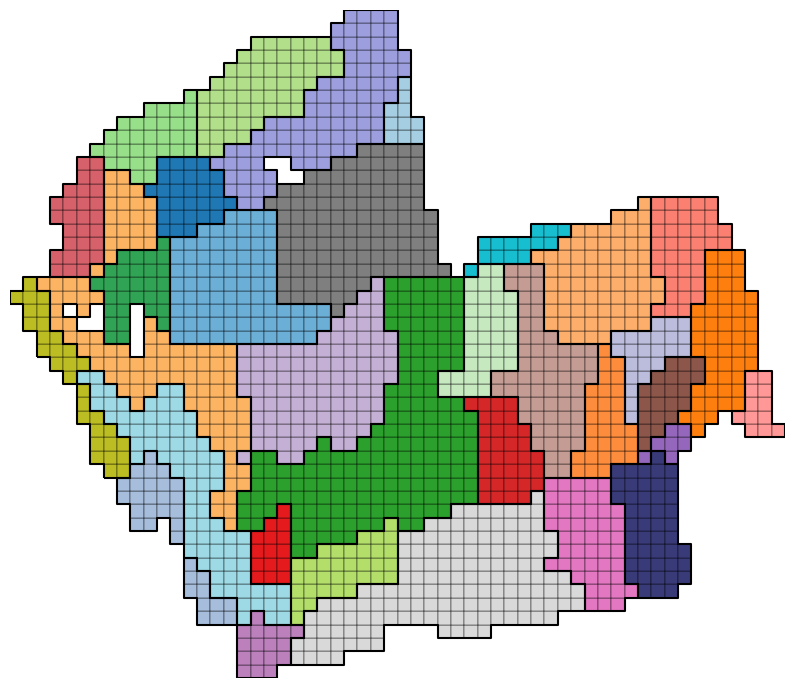

In [58]:
#visuzalization of cells

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


shapefile_path = path + "/Shapefile/2025-04-29_Full_optimal_segments.shp"
gdf = gpd.read_file(shapefile_path)

#define fixed palette
soft_colors = [
    "#bcbd22", "#9c9ede", "#fb8072", "#fdb462", "#7f7f7f", "#bc80bd",
    "#6baed6", "#fdae6b", "#ff7f0e", "#fd8d3c", "#e41a1c", "#8c564b",
    "#d62728", "#d6616b", "#1f77b4", "#98df8a", "#b2df8a", "#b3de69",
    "#a6bddb", "#c7e9c0", "#bcbddc", "#c49c94", "#393b79", "#17becf",
    "#ff9896", "#2ca02c", "#c5b0d5", "#31a354", "#d9d9d9", "#e377c2",
    "#9edae5", "#fdb462", "#a6cee3", "#9467bd"
]


n_colors = len(soft_colors)

unique_types = gdf['Bestands_I'].dropna().unique()
unique_types_sorted = sorted(unique_types)

type_to_color = {val: soft_colors[i % n_colors] for i, val in enumerate(unique_types_sorted)}
gdf['__color__'] = gdf['Bestands_I'].map(type_to_color)

fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, color=gdf['__color__'], linewidth=0.3, edgecolor='black')

dissolved = gdf.dissolve(by='Bestands_I')
dissolved.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

ax.set_xlim(gdf.total_bounds[[0, 2]])
ax.set_ylim(gdf.total_bounds[[1, 3]])
ax.axis("off")
plt.savefig(path + "/Figures/delineated_stands.png", dpi=500)
plt.savefig(path + "/Figures/delineated_stands.tiff", dpi=500)
plt.show()


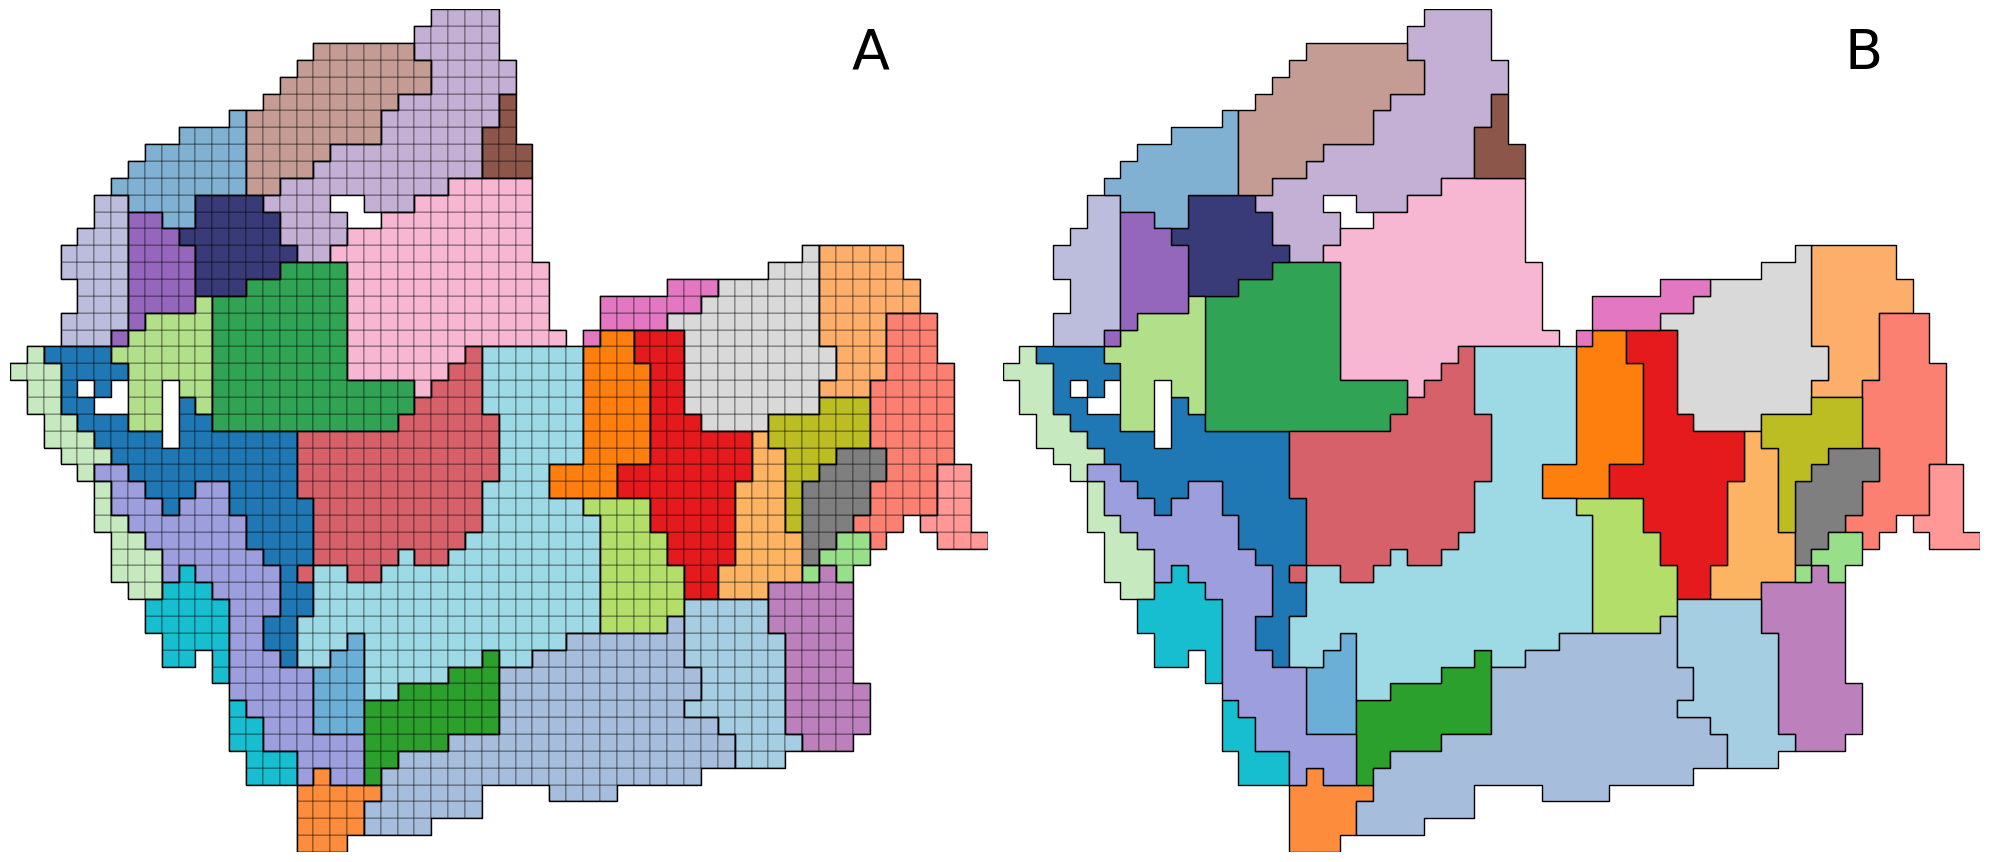

In [85]:
#visualize cells and stands

import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = path + "/Shapefile/2025-04-29_Full_optimal_segments.shp"
gdf = gpd.read_file(shapefile_path)

soft_colors = [
    "#c7e9c0", "#c5b0d5", "#fdae6b", "#1f77b4", "#f7b6d2", "#fd8d3c",
    "#31a354", "#d9d9d9", "#fb8072", "#fdb462", "#6baed6", "#7f7f7f",
    "#b3de69", "#bcbddc", "#393b79", "#80b1d3", "#c49c94", "#2ca02c",
    "#17becf", "#ff7f0e", "#bcbd22", "#e41a1c", "#bc80bd", "#e377c2",
    "#ff9896", "#9edae5", "#d6616b", "#b2df8a", "#a6bddb", "#a6cee3",
    "#9c9ede", "#9467bd", "#8c564b", "#98df8a"
]

n_colors = len(soft_colors)

unique_types = gdf['Bestands_I'].dropna().unique()
unique_types_sorted = sorted(unique_types)

type_to_color = {val: soft_colors[i % n_colors] for i, val in enumerate(unique_types_sorted)}
gdf['__color__'] = gdf['Bestands_I'].map(type_to_color)

gdf_dissolved = gdf.dissolve(by='Bestands_I')
gdf_dissolved['__color__'] = gdf_dissolved.index.map(type_to_color)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
ax1, ax2 = axes

xlim = gdf.total_bounds[[0, 2]]
ylim = gdf.total_bounds[[1, 3]]

#LEFT PLOT - cells
gdf.plot(ax=ax1, color=gdf['__color__'], linewidth=0.3, edgecolor='black')
gdf_dissolved.boundary.plot(ax=ax1, edgecolor='black', linewidth=1)
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.axis("off")

ax1.text(0.90, 0.98, "A", transform=ax1.transAxes,
         fontsize=40,  ha='right', va='top')

#RIGHT PLOT - stands
gdf_dissolved.plot(ax=ax2, color=gdf_dissolved['__color__'], edgecolor='black', linewidth=1)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.axis("off")

ax2.text(0.90, 0.98, "B", transform=ax2.transAxes,
         fontsize=40, ha='right', va='top')

import matplotlib.patches as patches

plt.tight_layout()
plt.savefig(path + "/Figures/delineated_stands_side_by_side_3.png", dpi=500)
plt.savefig(path + "/Figures/delineated_stands_side_by_side_3.tiff", dpi=500)
plt.show()
